### Posterior Predictive Check for Fully Bayesian Unfolding, First Excited state of 28Si 

In [1]:
import ompy as om 
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as mc
import scipy as sp
from theano import tensor as T
import theano; theano.gof.cc.get_module_cache().clear()
import pandas as pd 
import fbu

<IPython.core.display.Javascript object>


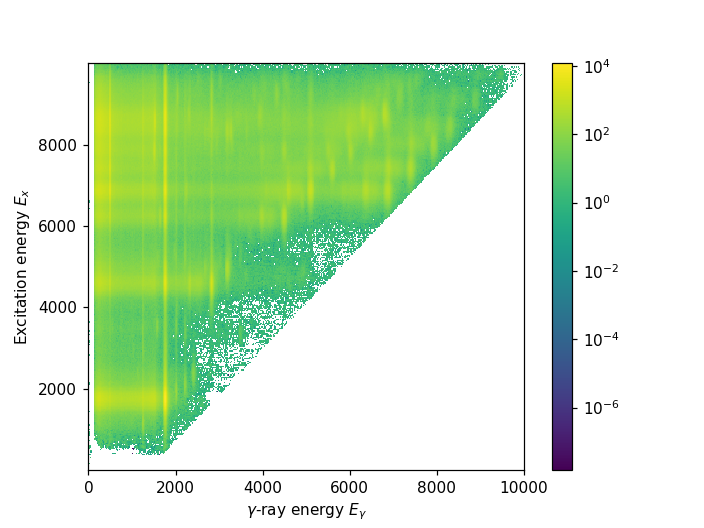

(322, 500)


In [2]:
%matplotlib notebook

# Reading the data 
raw = om.Matrix(path="/home/vala/Downloads/h_Ex_Eg_improved_bgsubtr_noneg_28Si.m")


#Setting every count below this diagonal to zero
raw.cut_diagonal(E1=(1800, 500), E2=(10500, 10000))

# Cutting raw matrix 
raw.cut('Ex',0, 10000)
raw.cut('Eg', 0, 10000)

#Rebinning 
raw.rebin(axis= "Eg", factor=4)

raw.plot()

print(raw.shape)
#Projecting the first excited state to the Eg axis
raw_py, E = raw.projection(axis="Eg", Emin=1400, Emax=2200)

Eg = raw.Eg


<IPython.core.display.Javascript object>


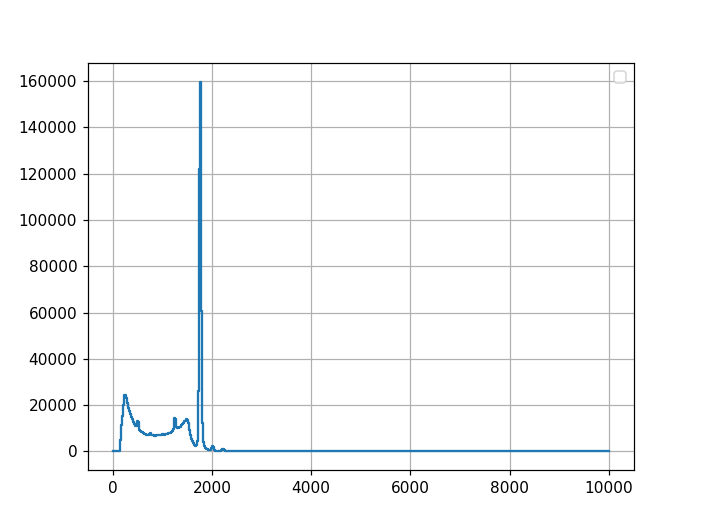

No handles with labels found to put in legend.


In [3]:
%matplotlib notebook

#Plot of projected raw spectrum
plt.plot(Eg, raw_py, ls='steps')
plt.legend()
plt.grid()
plt.show()

In [4]:
# Cutting out the zeros from the projected raw spectrum 

thres = 7 #bin number 7 -> Eg = 140 keV 

print(Eg[7])
print(Eg[163])
lst = np.where(raw_py==0)
raw_bay = raw_py[thres:163] #bin number 163 -> Eg = 3266 keV 
energy = Eg[thres:163]

print(len(raw_bay))

156


<IPython.core.display.Javascript object>


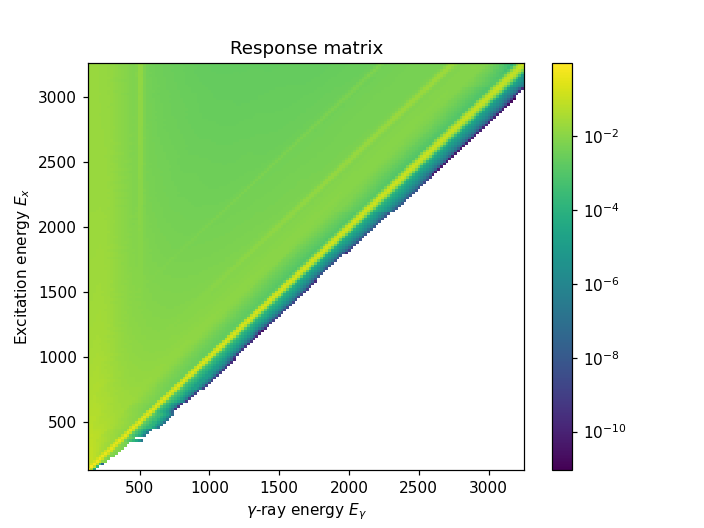

(<matplotlib.collections.QuadMesh at 0x7ff39c7a5f50>,
 <Figure size 640x480 with 2 Axes>)

In [5]:
#Initiating the matrix for usage in FBU. Using the cut energy instead of Eg

fwhm_abs = 30.0
folderpath = "/home/vala/Documents/Master/MachineLearning/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_bay, R_tab_bay = response.interpolate(energy, fwhm_abs=fwhm_abs, return_table=True)
R_bay_unf, R_tab_bay_unf = response.interpolate(energy, fwhm_abs=fwhm_abs/10, return_table=True)

R_bay.plot(title="Response matrix", scale='log')

In [6]:
# Scaling the response with efficiency. 
eff = 0.5*R_tab_view["eff_tot"].values

pFE = R_tab_view['pFE'].values


resp =R_ompy_view.values*eff[:,np.newaxis] 

<IPython.core.display.Javascript object>


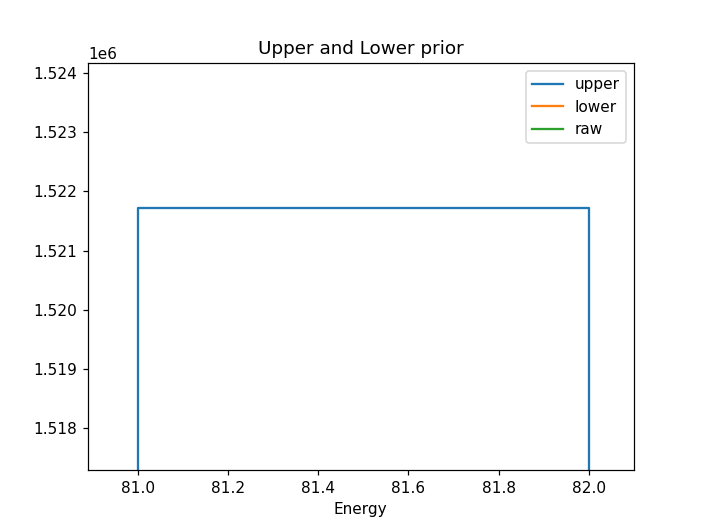

In [7]:
%matplotlib notebook
#Initiating priors upper and lower bound
prior_l = np.zeros(len(raw_bay))
prior_u = raw_bay/(eff*pFE) 
prior_u[81] += 30000 
prior_u[82] += 250000
prior_u[85:] +=40000
plt.plot(prior_u,ls='steps',markersize=2, label = 'upper')
plt.plot(prior_l@resp, ls='steps', label = 'lower')
plt.plot(raw_bay, ls='steps', label= 'raw')
plt.title('Upper and Lower prior')
plt.xlabel('Energy')
plt.legend()
plt.show()  

In [8]:
#FBU:
myfbu = fbu.PyFBU()

In [9]:
# FBU response
myfbu.response = resp
print(myfbu.response.shape)

(156, 156)


In [10]:
#FBU data and prior
myfbu.data =raw_bay
myfbu.prior = 'Uniform'
myfbu.upper = prior_u   
myfbu.lower = prior_l


In [37]:
# Sampling and tuning 
myfbu.nTune = 1000
myfbu.nMCMC = 5000

# Running posterior predictive check
myfbu.ppc = True
myfbu.nCores = 2

In [38]:
#Running FBU 
myfbu.run()

hei


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


None


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [truth155, truth154, truth153, truth152, truth151, truth150, truth149, truth148, truth147, truth146, truth145, truth144, truth143, truth142, truth141, truth140, truth139, truth138, truth137, truth136, truth135, truth134, truth133, truth132, truth131, truth130, truth129, truth128, truth127, truth126, truth125, truth124, truth123, truth122, truth121, truth120, truth119, truth118, truth117, truth116, truth115, truth114, truth113, truth112, truth111, truth110, truth109, truth108, truth107, truth106, truth105, truth104, truth103, truth102, truth101, truth100, truth99, truth98, truth97, truth96, truth95, truth94, truth93, truth92, truth91, truth90, truth89, truth88, truth87, truth86, truth85, truth84, truth83, truth82, truth81, truth80, truth79, truth78, truth77, truth76, truth75, truth74, truth73, truth72, truth71, truth70, truth69, truth68, truth67, truth66, truth65, truth64, truth63, truth62, truth61, truth60, truth59, truth58, truth57, tru

Elapsed 0:18:41 (10.70 samples/second)


In [40]:
# Getting the posterior predictive check
ppc = myfbu.post_pred

In [20]:
np.asarray(ppc['unfolded']).shape

(500, 156)

In [45]:
post_array = np.asarray(ppc['unfolded'])


500


500


<IPython.core.display.Javascript object>


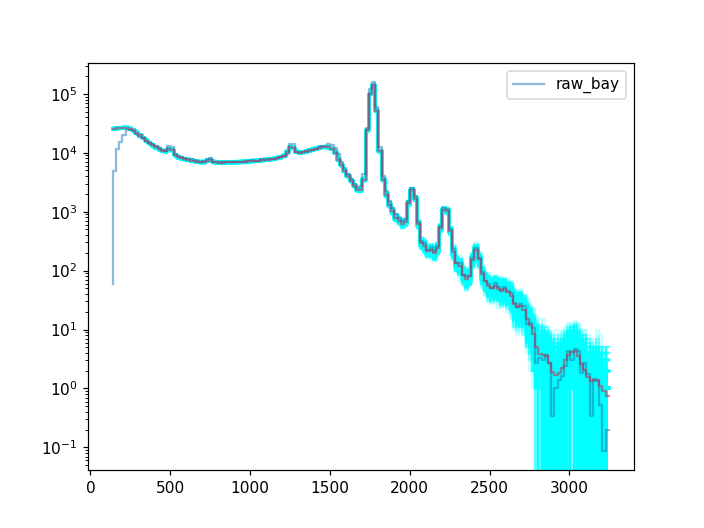

In [59]:
# Plotting the posterior predictive check with raw spectrum
%matplotlib notebook
post_array = np.asarray(ppc['unfolded'])


mean_post = np.mean(post_array, axis=0)

for i in range(len(post_array)):
    plt.plot(energy, post_array[i], color="cyan", ls='steps', alpha=0.2)

plt.plot(energy, raw_bay,ls='steps', label='raw_bay', alpha=0.5)
plt.plot(energy, mean_post, color='crimson', ls='steps', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

In [56]:
# Saving posterior predictive to file 
cols = []
for i in range(len(post_array)):
    name = 'unfolded%d'%i
    
    cols.append(name)

df = pd.DataFrame(dict(zip(cols,post_array)))

df.to_csv('post_pred_check_1stEx_290720.csv', index=False)